- Load necessary module

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [2]:
mat = io.loadmat('temp.mat')
model = {}
model['H'] = mat['H']
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
model['Ns'] = 1 ## need to change nb of stream in channel realization, this case 1
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 2

In [3]:
for key in model:
    print(key)

H
Wopt
Fopt
Ns
Nt
Nr
Nc
Nray
realization
At
Ar
Nrf


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

# Cross Entropy Beamforming

### Helper function for Cross entropy Beamforming

In [4]:
def phase_shifter(n_bit,n_ant):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**n_bit
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i/np.sqrt(n_ant)
    return np.around(ps, decimals=2)

def generate_candidat(S,model,phase_value,ps_system_proba):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    for i in range(S):
        for j in range(model['Nt']):
            for k in range(model['Nrf']):
                F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    return F_rf

def compute_Fbb(F_rf,model):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
    channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  model['H'][:,:,channel_index]@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
        F_bb[i,:,:] = np.sqrt(model['Ns'])*F_bb[i,:,:]/np.linalg.norm(F_rf[i,:,:]@F_bb[i,:,:],'fro')
    return F_bb

def optimal_beamformer(model, channel_index):
    """
    Compute the optimal beamformer by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Fopt -- optimal precoder
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    Fopt = np.zeros((model['Nt'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(model['H'][:,:,channel_index], full_matrices=True)
    V = V.conj().T
    Fopt = V[0:model['Nt'],0:model['Ns']]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Fopt, Wopt


def update_pmf(F_elites,phase_value,nb_elite):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    
    Returns:
    ps_system_proba -- pmf of phase shifter
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    for i in range(model['Nt']):
        for j in range(model['Nrf']):
            unique, counts = np.unique(F_elites[:,i,j], return_counts=True)
            value_count = dict(zip(unique, counts))
            for k in range(nb_state):
                if phase_value[k] in value_count:   
                    proba_est = value_count[phase_value[k]]/nb_elite
                else:
                    proba_est = 0
                ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    return ps_system_proba

def data_rate(Ns,SNR,W,H,F):
    """
    Compute the data rate of the beamforming system
    
    Arguments:
    Ns -- number of stream
    SNR -- Signal to noise ratio
    W -- combiner
    H -- channel
    F -- precoder
    
    Returns:
    R -- data rate
    """
    R = np.log2(np.linalg.det(np.eye(Ns)+SNR/Ns*np.linalg.pinv(W)@H@F@F.conj().T@H.conj().T@W))
    return R.real

### Define Phase shiter

In [5]:
nb_bit = 4
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [6]:
phase_value = phase_shifter(nb_bit,model['Nt'])
phase_value

array([ 0.12+0.  j,  0.12+0.05j,  0.09+0.09j,  0.05+0.12j, -0.  +0.12j,
       -0.05+0.12j, -0.09+0.09j, -0.12+0.05j, -0.12-0.  j, -0.12-0.05j,
       -0.09-0.09j, -0.05-0.12j,  0.  -0.12j,  0.05-0.12j,  0.09-0.09j,
        0.12-0.05j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [7]:
nb_elite = 40
S = 200
channel_index = 0
Fopt, Wopt = optimal_beamformer(model,channel_index)
nb_iterate = 30
ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
# R_max = np.zeros((nb_iterate))
proba_evo = np.copy(ps_system_proba[0,0,:])
print(proba_evo)
i = 0
relative_std = 1000 # initialize high value of relative standard deviation
SNR = 10**(10/10)
while ((i<nb_iterate) and (relative_std>3)):
    print(i)
    F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
    F_bb = compute_Fbb(F_rf,model)
    R = np.zeros((S))
    for j in range(S):
        R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
#         R[j] = np.log2(np.linalg.det(np.eye(model['Ns']))+SNR/model['Ns']*np.linalg.pinv(Wopt)@model['H'][:,:,channel_index]@F_rf[j,:,:]@F_bb[j,:,:]@F_bb[j,:,:].conj().T@F_rf[j,:,:].conj().T@model['H'][:,:,channel_index].conj().T@Wopt).real
    R_sort_index = np.argsort(R)[::-1][:nb_elite]
    if i==0:
        R_max = R[R_sort_index[0]]
    else:
        R_max = np.append(R_max,R[R_sort_index[0]])
    F_elites = F_rf[R_sort_index,:,:]
    Frf_max = F_rf[R_sort_index[0],:,:]
    Fbb_max = F_bb[R_sort_index[0],:,:]
    ps_system_proba = update_pmf(F_elites,phase_value,nb_elite)
    proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
    if i>=5:
        R_max_normalize = R_max-np.min(R_max) ## Need to review
        relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
        print(relative_std)
    i +=1
    

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0
1
2
3
4
5
80.3146040790676
6
70.93963639093244
7
72.4371244843691
8
44.92153570348471
9
28.3063161757048
10
20.636507217512943
11
13.598610774265719
12
12.003224576065646
13
8.646358780927
14
7.9139512437881425
15
5.338016202542287
16
3.2118292340038153
17
2.438455843319559


In [8]:
R_max.shape

(18,)

In [9]:
# Evolution of pmf of 1 phase shifter
np.around(proba_evo, decimals=2)

array([[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06,
        0.06, 0.06, 0.06, 0.06, 0.06],
       [0.05, 0.12, 0.05, 0.01, 0.03, 0.05, 0.14, 0.05, 0.12, 0.07, 0.03,
        0.03, 0.05, 0.03, 0.05, 0.12],
       [0.07, 0.15, 0.1 , 0.  , 0.  , 0.01, 0.15, 0.05, 0.17, 0.12, 0.07,
        0.03, 0.01, 0.  , 0.01, 0.08],
       [0.07, 0.13, 0.14, 0.  , 0.  , 0.  , 0.1 , 0.01, 0.24, 0.12, 0.05,
        0.  , 0.  , 0.  , 0.  , 0.12],
       [0.07, 0.1 , 0.13, 0.  , 0.  , 0.  , 0.08, 0.  , 0.18, 0.24, 0.07,
        0.  , 0.  , 0.  , 0.  , 0.12],
       [0.05, 0.08, 0.1 , 0.  , 0.  , 0.  , 0.01, 0.  , 0.15, 0.38, 0.07,
        0.  , 0.  , 0.  , 0.  , 0.15],
       [0.07, 0.05, 0.06, 0.  , 0.  , 0.  , 0.02, 0.  , 0.2 , 0.44, 0.1 ,
        0.  , 0.  , 0.  , 0.  , 0.06],
       [0.07, 0.1 , 0.1 , 0.  , 0.  , 0.  , 0.05, 0.  , 0.2 , 0.38, 0.08,
        0.  , 0.  , 0.  , 0.  , 0.03],
       [0.07, 0.1 , 0.05, 0.  , 0.  , 0.  , 0.03, 0.  , 0.27, 0.4 , 0.08,
        0.  , 0.  , 0.

In [10]:
proba_evo.shape

(19, 16)

[ 8.7025576   9.0658577   8.51727589  8.8690823   9.47057646  9.76746798
 10.26068342 10.40561741 10.74937606 10.87182103 11.04802775 11.23682036
 11.33723885 11.4710324  11.41076142 11.48636895 11.54779606 11.59085674]


Text(0.5,0,'iteration')

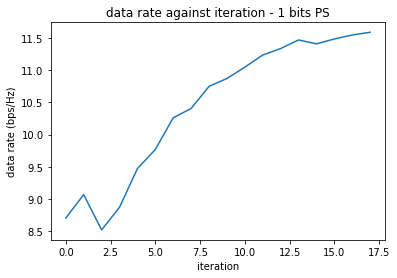

In [11]:
print(R_max)
plt.plot(R_max)
plt.title('data rate against iteration - 1 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate

# Digital Beamforming

In [12]:
R_o = data_rate(model['Ns'],SNR,model['Wopt'][:,[0],0],model['H'][:,:,0],model['Fopt'][:,[0],0])
print(R_o)

11.968975659591255


In [13]:
F_rf

array([[[-0.12-0.05j,  0.12-0.05j],
        [ 0.  -0.12j,  0.09+0.09j],
        [ 0.12-0.05j,  0.05-0.12j],
        ...,
        [-0.09-0.09j, -0.12-0.  j],
        [ 0.12-0.05j,  0.  -0.12j],
        [-0.12-0.  j,  0.12+0.05j]],

       [[-0.12-0.05j, -0.05-0.12j],
        [ 0.  -0.12j,  0.12+0.05j],
        [ 0.12+0.  j,  0.05-0.12j],
        ...,
        [-0.05-0.12j, -0.12-0.  j],
        [ 0.05-0.12j,  0.  -0.12j],
        [-0.12-0.  j,  0.12+0.05j]],

       [[-0.12-0.05j, -0.05-0.12j],
        [ 0.05-0.12j,  0.05+0.12j],
        [ 0.12-0.05j,  0.05-0.12j],
        ...,
        [-0.05-0.12j, -0.12-0.  j],
        [ 0.05-0.12j,  0.  -0.12j],
        [-0.12-0.  j,  0.12+0.05j]],

       ...,

       [[-0.12-0.05j, -0.05-0.12j],
        [-0.05-0.12j, -0.05+0.12j],
        [ 0.12+0.  j,  0.05-0.12j],
        ...,
        [-0.09-0.09j, -0.12+0.05j],
        [ 0.09-0.09j,  0.  -0.12j],
        [-0.12-0.  j,  0.05+0.12j]],

       [[-0.12-0.  j, -0.05-0.12j],
        [ 0.  -0.12j,  0.05

In [14]:
# Normalize condition
x = np.linalg.norm(F_rf[1,:,:]@F_bb[1,:,:],'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 1    Frobenius norm FRF*FBB= 0.9999999999999998
